# Demand Forecasting and Supply Planning App

Demand Forecast Process
- Get sales data
- Map and model hierarchies
- Select set of forecasting algorithms to try
- Train on section of sales data
- Crossvalidation
- Select best forecasts for each series
- Make forecasts
- Reconcile hierarchies
- Return demand forecasts

Supply Planning Process
- Get inventory data and demand forecasts
- Get difference between current inventory and forecasted demand
- Calculate amount needed to meet expected demand
- Return supply recommendation

In [1]:
import pandas as pd
import numpy as np
from utilsforecast.losses import mse, rmse, mae, mape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExponentiallyWeightedMean
from mlforecast.target_transforms import LocalStandardScaler, Differences
import time
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    SeasonalNaive,
    SeasonalWindowAverage,
    CrostonClassic,
    CrostonOptimized,
    HistoricAverage,
    Naive,
    AutoETS,
    AutoCES,
    AutoMFLES,
)

In [2]:
df = pd.read_csv(r"C:\Users\bwynd\allocation_tool\test_input_data.csv")

In [3]:
df

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
58327365,58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24
58327366,58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327367,58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327368,58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
fiscal_year = pd.read_csv(r"C:\Users\bwynd\OneDrive\Desktop\demand_supply_planning_app\fiscal_calendar_forecasting.csv")

In [6]:
fiscal_year = fiscal_year[['day_date','fiscal_week_of_year','fiscal_day_of_week']]

In [7]:
fiscal_year['day_date'] = pd.to_datetime(fiscal_year['day_date'])

In [8]:
df = df.merge(fiscal_year, how='left', left_on='date',right_on='day_date')

In [9]:
df

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,day_date,fiscal_week_of_year,fiscal_day_of_week
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,2011-01-29,52,7
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,2011-01-29,52,7
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,2011-01-29,52,7
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,2011-01-29,52,7
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,2011-01-29,52,7
...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24,2016-04-24,13,1
58327366,58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24,2016-04-24,13,1
58327367,58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24,2016-04-24,13,1
58327368,58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24,2016-04-24,13,1


In [10]:
df = df.groupby(['state_id','store_id','cat_id','dept_id','item_id', pd.Grouper(key='date', freq='W-SUN')])['Sales'].sum().reset_index().sort_values('date')

In [11]:
df.rename(columns={'Sales':'y','date':'ds'},inplace=True)

In [12]:
df

,state_id,store_id,cat_id,dept_id,item_id,ds,y
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,2011-01-30,3
5755644,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_179,2011-01-30,1
5755370,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_178,2011-01-30,0
363872,CA,CA_1,FOODS,FOODS_3,FOODS_3_717,2011-01-30,0
5755096,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_177,2011-01-30,0
...,...,...,...,...,...,...,...
5550417,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_110,2016-04-24,0
5550691,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_111,2016-04-24,2
5550965,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_112,2016-04-24,2
5547677,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_100,2016-04-24,6


In [13]:
df['total'] = 'total'

In [161]:
df.to_csv('training_data_nonhierarchical.csv')

In [14]:
hierarchy_levels = [['total'],
                    ['total','state_id'],
                    ['total','state_id','store_id'],
                    ['total','state_id','store_id','cat_id'],
                    ['total','state_id','store_id','cat_id','dept_id'],
                    ['total','state_id','store_id','cat_id','dept_id','item_id']]

In [15]:
Y_hier_df, S_df, tags = aggregate(df=df, spec=hierarchy_levels)
Y_hier_df = Y_hier_df.reset_index()

In [16]:
Y_hier_df

,unique_id,ds,y
0,total,2011-01-30,64380
1,total,2011-02-06,196230
2,total,2011-02-13,193715
3,total,2011-02-20,172328
4,total,2011-02-27,166645
...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0


In [162]:
Y_hier_df.to_csv("hierarchical_df_training.csv")

In [17]:
S_df

,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_002,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_003,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_004,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_005,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_006,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_008,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_009,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_010,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_011,...,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_507,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_508,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_509,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_510,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_511,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_512,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_513,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_514,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_515,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516
total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
total/CA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total/TX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total/WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
total/CA/CA_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
tags

{'total': array(['total'], dtype=object),
 'total/state_id': array(['total/CA', 'total/TX', 'total/WI'], dtype=object),
 'total/state_id/store_id': array(['total/CA/CA_1', 'total/CA/CA_2', 'total/CA/CA_3', 'total/CA/CA_4',
        'total/TX/TX_1', 'total/TX/TX_2', 'total/TX/TX_3', 'total/WI/WI_1',
        'total/WI/WI_2', 'total/WI/WI_3'], dtype=object),
 'total/state_id/store_id/cat_id': array(['total/CA/CA_1/FOODS', 'total/CA/CA_1/HOBBIES',
        'total/CA/CA_1/HOUSEHOLD', 'total/CA/CA_2/FOODS',
        'total/CA/CA_2/HOBBIES', 'total/CA/CA_2/HOUSEHOLD',
        'total/CA/CA_3/FOODS', 'total/CA/CA_3/HOBBIES',
        'total/CA/CA_3/HOUSEHOLD', 'total/CA/CA_4/FOODS',
        'total/CA/CA_4/HOBBIES', 'total/CA/CA_4/HOUSEHOLD',
        'total/TX/TX_1/FOODS', 'total/TX/TX_1/HOBBIES',
        'total/TX/TX_1/HOUSEHOLD', 'total/TX/TX_2/FOODS',
        'total/TX/TX_2/HOBBIES', 'total/TX/TX_2/HOUSEHOLD',
        'total/TX/TX_3/FOODS', 'total/TX/TX_3/HOBBIES',
        'total/TX/TX_3/HOUSEHOL

In [19]:
bottom_array = tags['total/state_id/store_id/cat_id/dept_id/item_id']

In [20]:
Y_test_df = Y_hier_df.groupby('unique_id').tail(6)
Y_train_df = Y_hier_df.drop(Y_test_df.index)

In [21]:
Y_test_df

,unique_id,ds,y
268,total,2016-03-20,287425
269,total,2016-03-27,287458
270,total,2016-04-03,291571
271,total,2016-04-10,310767
272,total,2016-04-17,296009
...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0


# EDA

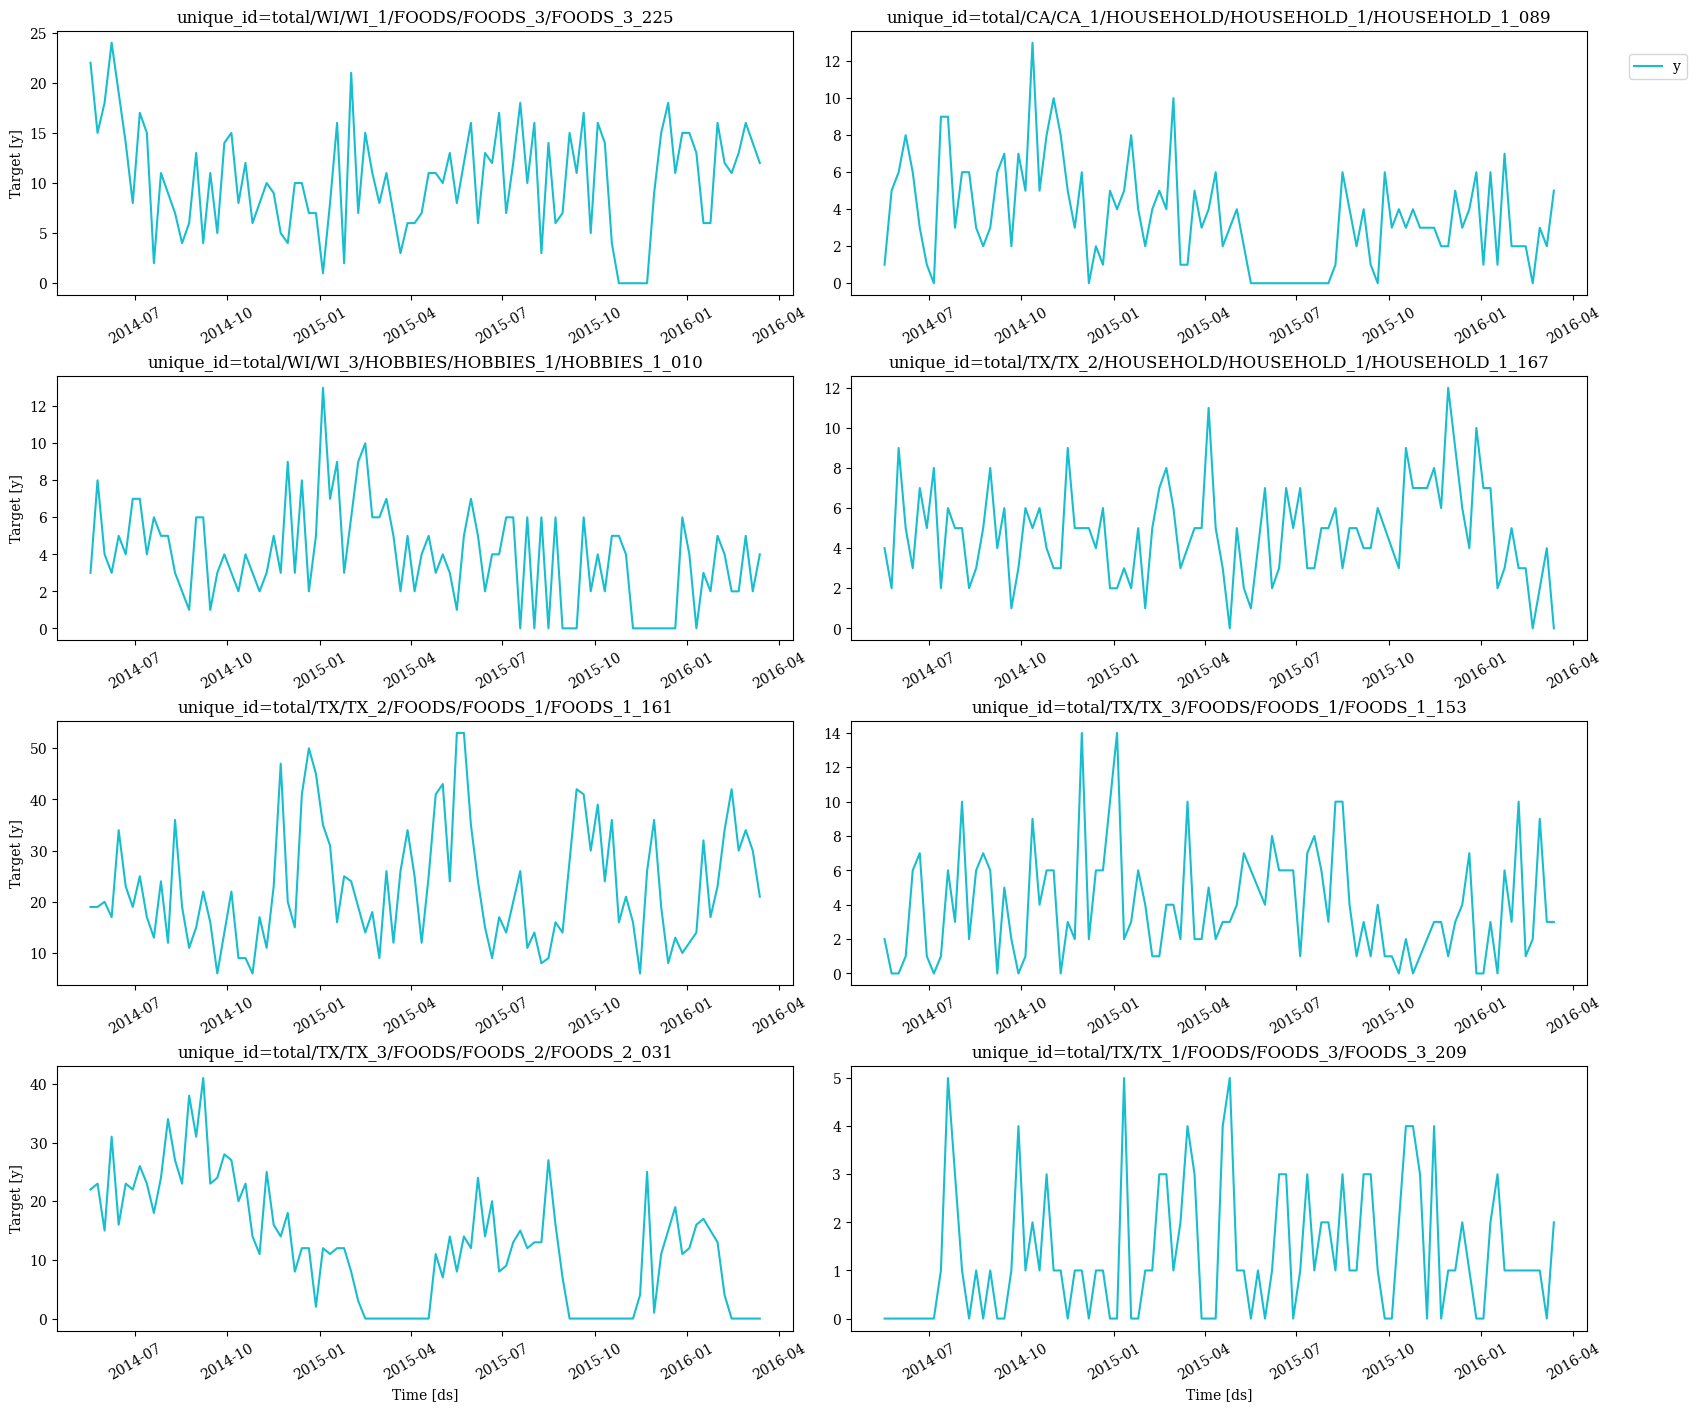

In [22]:
fig = plot_series(Y_train_df, max_insample_length=4*24)
fig

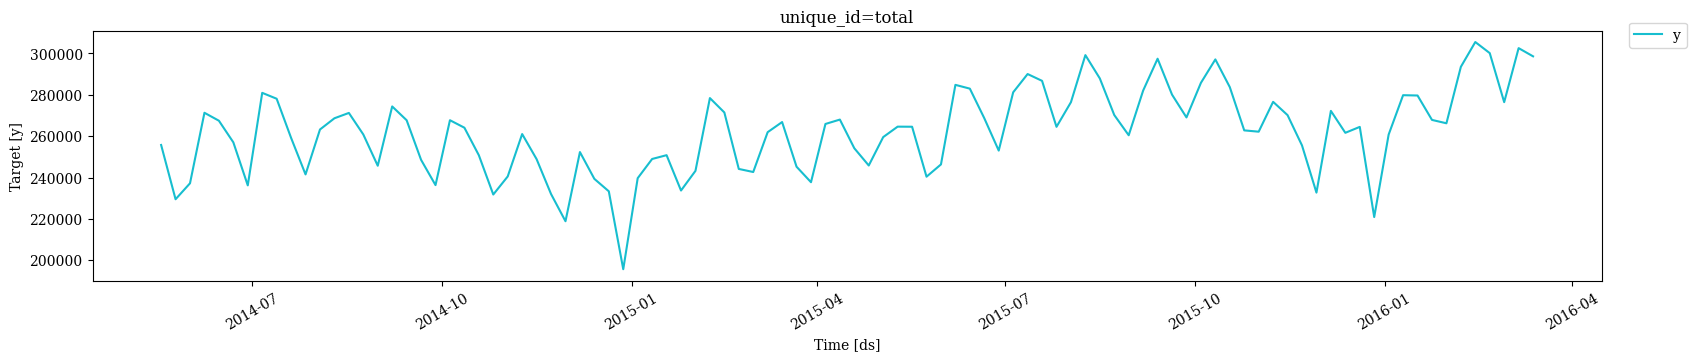

In [23]:
fig = plot_series(Y_train_df[Y_train_df['unique_id'].isin(['total'])], max_insample_length=4*24)
fig

# Feature Engineering

In [24]:
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExponentiallyWeightedMean, ExpandingStd
from mlforecast.target_transforms import LocalStandardScaler, Differences
import seaborn as sns

In [25]:
fcst = MLForecast(
    models=[],
    freq='W',
    lags=[1,2,4,52,104],
)
prep = fcst.preprocess(Y_train_df)
prep.drop(columns=['unique_id','ds']).corr()['y']

y         1.000000
lag1      0.996780
lag2      0.994295
lag4      0.997918
lag52     0.996696
lag104    0.988572
Name: y, dtype: float64

In [26]:
fcst = MLForecast(
    models=[],
    freq='W',
    lags=[1,4,52],
    lag_transforms={
        1:[RollingMean(window_size=4)],
        4:[RollingMean(window_size=4),ExponentiallyWeightedMean(alpha=.8)],
        52:[ExponentiallyWeightedMean(alpha=.8)]
    }
)
prep = fcst.preprocess(Y_train_df)
prep.drop(columns=['unique_id','ds']).corr()['y']

# lag 1
# lag 4
# lag 52
# rolling_mean_lag4_window_size4
# exponentially weighted mean lag4 alpha 0.8
# exponentially_weighted_mean_lag52_alpha0.8
# rolling_mean_lag1_window_size4

y                                             1.000000
lag1                                          0.996537
lag4                                          0.997824
lag52                                         0.993169
rolling_mean_lag1_window_size4                0.997483
rolling_mean_lag4_window_size4                0.996767
exponentially_weighted_mean_lag4_alpha0.8     0.998102
exponentially_weighted_mean_lag52_alpha0.8    0.993248
Name: y, dtype: float64

In [27]:
corr = prep.drop(columns=['unique_id','ds']).corr()

In [28]:
corr

,y,lag1,lag4,lag52,rolling_mean_lag1_window_size4,rolling_mean_lag4_window_size4,exponentially_weighted_mean_lag4_alpha0.8,exponentially_weighted_mean_lag52_alpha0.8
y,1.000000,0.996537,0.997824,0.993169,0.997483,0.996767,0.998102,0.993248
lag1,0.996537,1.000000,0.994677,0.989704,0.998019,0.997295,0.995886,0.990959
lag4,0.997824,0.994677,1.000000,0.992697,0.998001,0.997993,0.999867,0.992662
lag52,0.993169,0.989704,0.992697,1.000000,0.991571,0.991521,0.992881,0.999830
rolling_mean_lag1_window_size4,0.997483,0.998019,0.998001,0.991571,1.000000,0.999310,0.998548,0.992276
rolling_mean_lag4_window_size4,0.996767,0.997295,0.997993,0.991521,0.999310,1.000000,0.998745,0.992280
exponentially_weighted_mean_lag4_alpha0.8,0.998102,0.995886,0.999867,0.992881,0.998548,0.998745,1.000000,0.993052
exponentially_weighted_mean_lag52_alpha0.8,0.993248,0.990959,0.992662,0.999830,0.992276,0.992280,0.993052,1.000000


<Axes: >

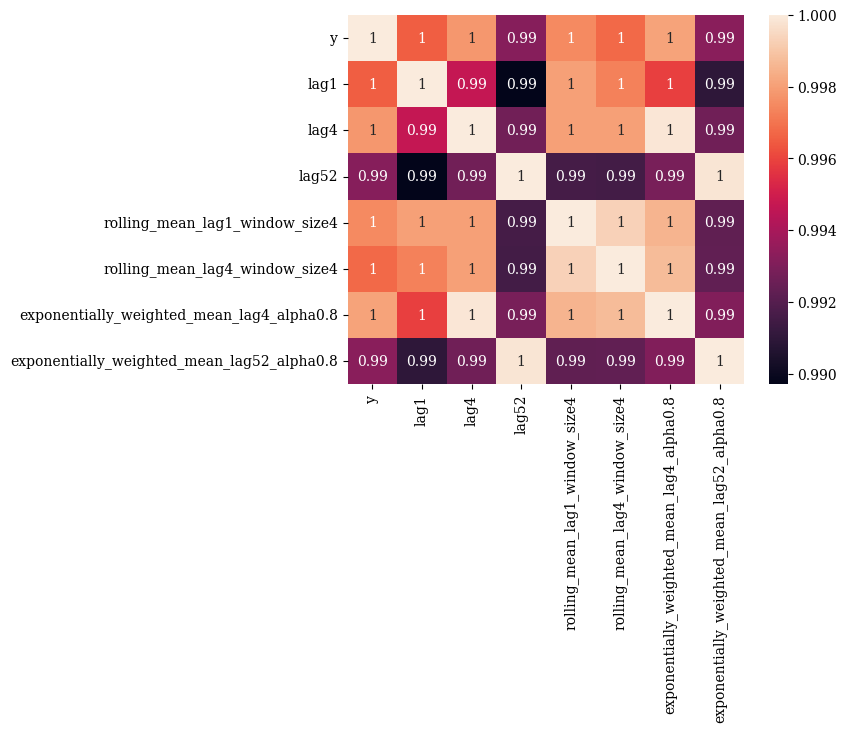

In [29]:
sns.heatmap(corr, annot=True)
# lag 1
# lag 4
# lag 52
# rolling_mean_lag4_window_size4|
# exponentially weighted mean lag4 alpha 0.8
# exponentially_weighted_mean_lag52_alpha0.8
# rolling_mean_lag1_window_size4

# LightGBM

In [30]:
import lightgbm as lgb

In [81]:
start_time = time.time()
lgb_params = {
    'verbosity': -1,
    'num_leaves': 30,
}

fcst = MLForecast(
    models={
        'tweedie': lgb.LGBMRegressor(**lgb_params, objective='tweedie'),
        'regression': lgb.LGBMRegressor(**lgb_params, objective='regression'),
        'l1reg': lgb.LGBMRegressor(**lgb_params, objective='regression_l1'),
    },
    freq='W',
    lags=[1,4,52],
    lag_transforms={
        1:[RollingMean(window_size=4)],
        4:[RollingMean(window_size=4),ExponentiallyWeightedMean(alpha=.8)],
        52:[ExponentiallyWeightedMean(alpha=.8)],
    },
)
fcst.fit(Y_train_df)
print("--- %s seconds ---" % (time.time() - start_time))

--- 23.653807640075684 seconds ---


In [82]:
start_time = time.time()
Y_hat_ml = fcst.predict(6)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.4493997097015381 seconds ---


In [83]:
Y_hat_ml

,unique_id,ds,tweedie,regression,l1reg
0,total,2016-03-20,223388.954008,230180.164182,129488.385461
1,total,2016-03-27,223388.954008,230180.164182,129488.385461
2,total,2016-04-03,223388.954008,230180.164182,129488.385461
3,total,2016-04-10,223388.954008,230180.164182,129488.385461
4,total,2016-04-17,223388.954008,230180.164182,129488.385461
...,...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0.976546,1.420610,0.821450
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0.826591,1.463861,0.324887
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0.870814,1.586371,0.716748
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0.905414,1.983814,0.441565


In [51]:
start_time = time.time()
crossval_ml = fcst.cross_validation(
    df=Y_train_df,
    h=6,
    step_size=1,
    n_windows=10
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 242.5381579399109 seconds ---


In [52]:
crossval_ml.reset_index(inplace=True)

In [53]:
crossval_ml

,index,unique_id,ds,cutoff,y,tweedie,regression,l1reg
0,0,total,2015-12-06,2015-11-29,272222,195525.002518,199587.809633,115851.816692
1,1,total,2015-12-13,2015-11-29,261621,195525.002518,199587.809633,115851.816692
2,2,total,2015-12-20,2015-11-29,264484,195525.002518,199587.809633,115851.816692
3,3,total,2015-12-27,2015-11-29,220882,195525.002518,199587.809633,115851.816692
4,4,total,2016-01-03,2015-11-29,260771,195525.002518,199587.809633,115851.816692
...,...,...,...,...,...,...,...,...
1836235,1836235,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-02-14,2016-01-31,0,0.894401,1.390888,0.731053
1836236,1836236,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-02-21,2016-01-31,0,0.964191,1.292235,0.727909
1836237,1836237,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-02-28,2016-01-31,1,0.883983,1.390888,0.613389
1836238,1836238,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-06,2016-01-31,0,0.875497,1.556438,0.495990


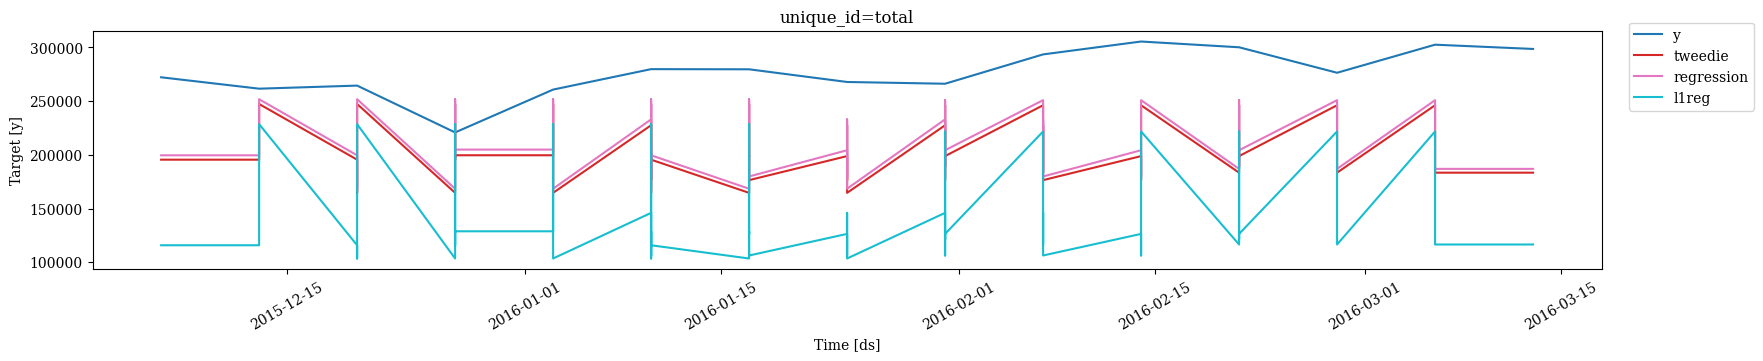

In [54]:
fig = plot_series(forecasts_df=crossval_ml[crossval_ml['unique_id'] == 'total'].drop(columns=['cutoff','index']))
fig

In [55]:
split_rmse = rmse(crossval_ml, models=['tweedie','regression','l1reg'], id_col='cutoff').set_index('cutoff')
split_rmse

,tweedie,regression,l1reg
cutoff,,,
2015-11-29,544.740356,541.718847,837.405416
2015-12-06,191.300823,176.494677,269.997839
2015-12-13,706.839078,701.319364,930.185775
2015-12-20,578.606011,501.087182,784.337373
2015-12-27,318.314264,290.723600,786.131300
2016-01-03,701.616154,694.034903,1018.713343
2016-01-10,662.685958,656.003038,926.052402
2016-01-17,676.231222,663.481838,957.741452
2016-01-24,286.935292,263.656033,423.193400


In [56]:
mae(crossval_ml, models=['tweedie','regression','l1reg'], id_col='cutoff').set_index('cutoff')

,tweedie,regression,l1reg
cutoff,,,
2015-11-29,10.142779,10.179498,11.313067
2015-12-06,7.463593,7.354222,8.539171
2015-12-13,12.453484,12.407613,12.702923
2015-12-20,10.525048,9.567145,11.629334
2015-12-27,9.352095,9.087975,13.643000
2016-01-03,12.695023,12.589728,13.973339
2016-01-10,12.456501,12.129455,13.299752
2016-01-17,12.237781,12.057804,13.383427
2016-01-24,8.065515,8.096485,9.543612


In [57]:
mape(crossval_ml, models=['tweedie','regression','l1reg'], id_col='cutoff').set_index('cutoff')

,tweedie,regression,l1reg
cutoff,,,
2015-11-29,0.587984,0.616311,0.564949
2015-12-06,0.592912,0.638339,0.567109
2015-12-13,0.597728,0.637023,0.569437
2015-12-20,0.611690,0.662434,0.582750
2015-12-27,0.575278,0.603182,0.560509
2016-01-03,0.567520,0.600332,0.553310
2016-01-10,0.561028,0.595646,0.549438
2016-01-17,0.561127,0.602886,0.543950
2016-01-24,0.547684,0.584467,0.537682


In [58]:
mse(crossval_ml, models=['tweedie','regression','l1reg'], id_col='cutoff').set_index('cutoff')

,tweedie,regression,l1reg
cutoff,,,
2015-11-29,296742.055089,293459.309524,7.012478e+05
2015-12-06,36596.004767,31150.370990,7.289883e+04
2015-12-13,499621.482045,491848.850503,8.652456e+05
2015-12-20,334784.915397,251088.363660,6.151851e+05
2015-12-27,101323.970353,84520.211606,6.180024e+05
2016-01-03,492265.227852,481684.447248,1.037777e+06
2016-01-10,439152.679090,430339.985408,8.575731e+05
2016-01-17,457288.664973,440208.149224,9.172687e+05
2016-01-24,82331.861715,69514.503529,1.790927e+05


# Statistical Methods

In [42]:
season_len = 52

In [43]:
models = [Naive(),
          SeasonalNaive(season_length=season_len),
          HistoricAverage(),
          SeasonalWindowAverage(season_length=season_len,window_size=4, alias="seasonal_window_avg_4"),
          SeasonalWindowAverage(season_length=season_len, window_size=8, alias="seasonal_window_avg_8"),
          CrostonClassic(),
          CrostonOptimized(),
          HoltWinters(season_length=season_len, error_type="A", alias="HoltWinters Add"),
          HoltWinters(season_length=season_len, error_type="M", alias="HoltWinters Multi"),
          AutoCES(season_length=season_len),
          AutoETS(model=["A","Z","N"], alias="AutoETS", season_length=season_len),
         ]

In [44]:
sf = StatsForecast(
    models=models,
    freq="W",
    fallback_model= SeasonalNaive(season_length=season_len),
    n_jobs=-1
)

In [85]:
start_time = time.time()
Y_hat_stats = sf.forecast(h=6, df=Y_train_df, fitted=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 718.5274574756622 seconds ---


C:\Users\bwynd\anaconda3\envs\demand_forecaster\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [46]:
start_time = time.time()
Y_fitted_df = sf.forecast_fitted_values()
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\bwynd\anaconda3\envs\demand_forecaster\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


--- 0.8547568321228027 seconds ---


In [98]:
Y_fitted_df

,ds,y,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
unique_id,,,,,,,,,,,,,
total,2011-01-30,64380.0,NaN,NaN,238570.515625,NaN,NaN,NaN,NaN,137764.468750,151858.984375,131175.953125,152947.640625
total,2011-02-06,196230.0,64380.0,NaN,238570.515625,NaN,NaN,64380.000000,64380.000000,155558.000000,168685.671875,138792.062500,130644.343750
total,2011-02-13,193715.0,196230.0,NaN,238570.515625,NaN,NaN,77565.000000,77565.000000,176293.125000,178947.859375,171349.859375,147160.265625
total,2011-02-20,172328.0,193715.0,NaN,238570.515625,NaN,NaN,89180.000000,130869.000000,176264.781250,175893.125000,175329.109375,158883.781250
total,2011-02-27,166645.0,172328.0,NaN,238570.515625,NaN,NaN,97494.796875,143306.703125,158021.859375,167532.546875,156936.937500,162269.328125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-02-14,0.0,1.0,0.0,0.910448,0.0,0.0,0.827745,0.827745,0.098525,0.000000,-0.020174,0.876947
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-02-21,0.0,0.0,2.0,0.910448,2.0,2.0,0.827745,0.827745,1.048990,2.000000,0.926981,0.876729
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-02-28,1.0,0.0,0.0,0.910448,0.0,0.0,0.827745,0.827745,1.286464,0.000000,1.052683,0.876460


In [47]:
start_time = time.time()
crossval_stats = sf.cross_validation(
    df=Y_train_df,
    h=6,
    step_size=1,
    n_windows=10
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3549.204781770706 seconds ---


C:\Users\bwynd\anaconda3\envs\demand_forecaster\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


# Selecting Models

In [72]:
crossval_merged = crossval_stats.merge(crossval_ml, how='inner', left_on=['unique_id','ds','cutoff'],right_on=['unique_id','ds','cutoff']).drop(columns=['y_y','index']).rename(columns={'y_x':'y'})

In [73]:
crossval_merged

,unique_id,ds,cutoff,y,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS,tweedie,regression,l1reg
0,total,2015-12-06,2015-11-29,272222.0,232692.0,252300.0,236310.312500,242066.25,NaN,268944.78125,257292.93750,264160.375000,264566.656250,279084.187500,260743.531250,195525.002518,199587.809633,115851.816692
1,total,2015-12-13,2015-11-29,261621.0,232692.0,239338.0,236310.312500,232708.25,NaN,268944.78125,257292.93750,254545.390625,255081.734375,269606.125000,260743.531250,195525.002518,199587.809633,115851.816692
2,total,2015-12-20,2015-11-29,264484.0,232692.0,233325.0,236310.312500,219081.50,NaN,268944.78125,257292.93750,240699.531250,238849.171875,256040.500000,260743.531250,195525.002518,199587.809633,115851.816692
3,total,2015-12-27,2015-11-29,220882.0,232692.0,195632.0,236310.312500,196574.25,NaN,268944.78125,257292.93750,219034.046875,217264.921875,233404.531250,260743.531250,195525.002518,199587.809633,115851.816692
4,total,2016-01-03,2015-11-29,260771.0,232692.0,239674.0,236310.312500,240257.25,NaN,268944.78125,257292.93750,261106.828125,263255.468750,277313.031250,260743.531250,195525.002518,199587.809633,115851.816692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836235,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-02-14,2016-01-31,0.0,0.0,0.0,0.919847,0.25,NaN,0.94347,0.94347,0.099043,0.000000,0.030923,0.883349,0.894401,1.390888,0.731053
1836236,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-02-21,2016-01-31,0.0,0.0,2.0,0.919847,1.25,NaN,0.94347,0.94347,1.071247,2.000000,0.973346,0.883268,0.964191,1.292235,0.727909
1836237,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-02-28,2016-01-31,1.0,0.0,0.0,0.919847,1.50,NaN,0.94347,0.94347,1.301456,0.000000,1.201815,0.883200,0.883983,1.390888,0.613389
1836238,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-06,2016-01-31,0.0,0.0,1.0,0.919847,1.50,NaN,0.94347,0.94347,1.500409,1.000000,1.382549,0.883143,0.875497,1.556438,0.495990


In [63]:
# https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html#select-the-best-model-for-every-unique-series
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [74]:
evaluation_df = evaluate_cross_validation(crossval_merged, rmse)

In [120]:
evaluation_df

,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS,tweedie,regression,l1reg,best_model
unique_id,,,,,,,,,,,,,,,
total,26689.578125,30639.666016,43046.570312,42261.457031,NaN,23216.232422,24833.277344,24103.435547,24245.244141,14447.451172,24896.931641,75683.031251,71605.864698,135853.639981,CES
total/CA,9270.109375,14490.906250,15283.909180,17235.208984,NaN,8057.638184,9024.456055,9615.675781,9576.998047,5443.935547,10309.426758,48774.134402,49379.943351,11097.287717,CES
total/CA/CA_1,2232.298096,1024.222900,2297.759033,2665.371094,NaN,1755.579712,1885.201904,1389.937256,1886.019165,1562.282837,2396.558838,1499.330535,1548.652233,2273.481597,SeasonalNaive
total/CA/CA_1/FOODS,1707.474243,1426.662109,1321.168213,1197.351807,NaN,1434.391846,1549.976562,1526.461304,1907.409790,1573.175049,1908.547485,1217.686924,1131.080811,1716.023949,regression
total/CA/CA_1/FOODS/FOODS_1,497.096771,442.665771,323.489441,219.249176,NaN,317.956696,375.055481,318.413910,403.006104,239.130341,403.333252,352.561977,360.722321,429.337144,seasonal_window_avg_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_512,1.518370,1.556155,1.426331,1.776400,NaN,1.457588,1.457588,1.662779,1.556155,1.721597,1.440020,1.369665,1.270895,1.482331,regression
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_513,3.034236,3.812701,2.310679,2.619705,NaN,2.401839,2.406588,2.822934,3.812701,7.935939,2.539027,2.370663,2.444417,2.397921,HistoricAverage
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_514,0.493971,0.829317,0.755300,0.913158,NaN,0.538642,0.533656,0.703577,0.829317,0.677452,0.521541,0.764550,1.453432,0.492106,l1reg


In [76]:
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

In [77]:
summary_df

,0
best_model,
HoltWinters Multi,33
CES,1421
regression,1460
AutoETS,1547
SeasonalNaive,1609
seasonal_window_avg_4,1815
Naive,2156
CrostonOptimized,2276
l1reg,2352


In [78]:
# https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html#select-the-best-model-for-every-unique-series
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

In [89]:
Y_hat_ml

,unique_id,ds,tweedie,regression,l1reg
0,total,2016-03-20,223388.954008,230180.164182,129488.385461
1,total,2016-03-27,223388.954008,230180.164182,129488.385461
2,total,2016-04-03,223388.954008,230180.164182,129488.385461
3,total,2016-04-10,223388.954008,230180.164182,129488.385461
4,total,2016-04-17,223388.954008,230180.164182,129488.385461
...,...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0.976546,1.420610,0.821450
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0.826591,1.463861,0.324887
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0.870814,1.586371,0.716748
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0.905414,1.983814,0.441565


In [92]:
Y_hat_stats

,unique_id,ds,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
0,total,2016-03-20,298607.0,245218.0,238570.515625,245218.0,245218.0,280328.718750,292847.031250,251995.968750,247933.640625,278520.062500,290960.468750
1,total,2016-03-27,298607.0,237725.0,238570.515625,237725.0,237725.0,280328.718750,292847.031250,249598.843750,250321.437500,276865.531250,290960.468750
2,total,2016-04-03,298607.0,265895.0,238570.515625,265895.0,265895.0,280328.718750,292847.031250,279510.843750,280122.031250,306501.031250,290960.468750
3,total,2016-04-10,298607.0,268017.0,238570.515625,268017.0,268017.0,280328.718750,292847.031250,274499.593750,273528.093750,301709.687500,290960.468750
4,total,2016-04-17,298607.0,254146.0,238570.515625,254146.0,254146.0,280328.718750,292847.031250,258750.906250,253903.859375,286047.250000,290960.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,1.0,2.0,0.910448,2.0,2.0,0.714084,0.714084,1.062568,2.000000,0.787269,0.875765
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,1.0,0.0,0.910448,0.0,0.0,0.714084,0.714084,0.500672,0.000000,0.243564,0.875640
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.537309,1.000000,0.275463,0.875536
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.564150,1.000000,0.297056,0.875450


In [91]:
Y_hat_stats.reset_index(inplace=True)

In [93]:
Y_hat_merged = Y_hat_ml.merge(Y_hat_stats, how='inner', left_on=['unique_id','ds'], right_on=['unique_id','ds'])

In [94]:
Y_hat_merged

,unique_id,ds,tweedie,regression,l1reg,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
0,total,2016-03-20,223388.954008,230180.164182,129488.385461,298607.0,245218.0,238570.515625,245218.0,245218.0,280328.718750,292847.031250,251995.968750,247933.640625,278520.062500,290960.468750
1,total,2016-03-27,223388.954008,230180.164182,129488.385461,298607.0,237725.0,238570.515625,237725.0,237725.0,280328.718750,292847.031250,249598.843750,250321.437500,276865.531250,290960.468750
2,total,2016-04-03,223388.954008,230180.164182,129488.385461,298607.0,265895.0,238570.515625,265895.0,265895.0,280328.718750,292847.031250,279510.843750,280122.031250,306501.031250,290960.468750
3,total,2016-04-10,223388.954008,230180.164182,129488.385461,298607.0,268017.0,238570.515625,268017.0,268017.0,280328.718750,292847.031250,274499.593750,273528.093750,301709.687500,290960.468750
4,total,2016-04-17,223388.954008,230180.164182,129488.385461,298607.0,254146.0,238570.515625,254146.0,254146.0,280328.718750,292847.031250,258750.906250,253903.859375,286047.250000,290960.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0.976546,1.420610,0.821450,1.0,2.0,0.910448,2.0,2.0,0.714084,0.714084,1.062568,2.000000,0.787269,0.875765
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0.826591,1.463861,0.324887,1.0,0.0,0.910448,0.0,0.0,0.714084,0.714084,0.500672,0.000000,0.243564,0.875640
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0.870814,1.586371,0.716748,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.537309,1.000000,0.275463,0.875536
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0.905414,1.983814,0.441565,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.564150,1.000000,0.297056,0.875450


In [95]:
prod_forecasts_df = get_best_model_forecast(Y_hat_merged, evaluation_df)
prod_forecasts_df.head()

,unique_id,ds,best_model
0,total,2016-03-20,278520.06250
1,total,2016-03-27,276865.53125
2,total,2016-04-03,306501.03125
3,total,2016-04-10,301709.68750
4,total,2016-04-17,286047.25000


In [96]:
prod_forecasts_df.set_index('unique_id',inplace=True)

In [97]:
prod_forecasts_df

,ds,best_model
unique_id,,
total,2016-03-20,278520.062500
total,2016-03-27,276865.531250
total,2016-04-03,306501.031250
total,2016-04-10,301709.687500
total,2016-04-17,286047.250000
...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-03-27,0.821450
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-04-03,0.324887
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-04-10,0.716748


## Hierarchical Reconciliation

In [129]:
reconcilers = [TopDown(method='forecast_proportions')]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(
    Y_hat_df=prod_forecasts_df,
    Y_df=Y_hier_df,
    S=S_df, tags=tags
)

In [130]:
Y_rec_df

,ds,best_model,best_model/TopDown_method-forecast_proportions
unique_id,,,
total,2016-03-20,278520.062500,278520.062500
total,2016-03-27,276865.531250,276865.531250
total,2016-04-03,306501.031250,306501.031250
total,2016-04-10,301709.687500,301709.687500
total,2016-04-17,286047.250000,286047.250000
...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-03-27,0.821450,0.954866
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-04-03,0.324887,0.394807
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,2016-04-10,0.716748,0.713298


In [131]:
def hier_rmse(y, y_hat):
    return np.sqrt(np.mean((y-y_hat)**2))

evaluator = HierarchicalEvaluation(evaluators=[hier_rmse])
hier_eval = evaluator.evaluate(Y_hat_df=Y_rec_df, Y_test_df=Y_test_df.set_index('unique_id'), tags=tags)

In [132]:
hier_eval

,,best_model,best_model/TopDown_method-forecast_proportions
level,metric,,
Overall,hier_rmse,109.118718,106.44948
total,hier_rmse,11045.984055,11045.984055
total/state_id,hier_rmse,5399.814639,5423.404478
total/state_id/store_id,hier_rmse,2157.503202,2157.870535
total/state_id/store_id/cat_id,hier_rmse,1505.460978,1318.766595
total/state_id/store_id/cat_id/dept_id,hier_rmse,731.932393,705.153292
total/state_id/store_id/cat_id/dept_id/item_id,hier_rmse,9.701194,9.902717


In [133]:
hier_eval.to_csv('hierarchical_evaluations_summary.csv')

In [134]:
Y_rec_df.reset_index(inplace=True)

In [135]:
Y_rec_df

,unique_id,ds,best_model,best_model/TopDown_method-forecast_proportions
0,total,2016-03-20,278520.062500,278520.062500
1,total,2016-03-27,276865.531250,276865.531250
2,total,2016-04-03,306501.031250,306501.031250
3,total,2016-04-10,301709.687500,301709.687500
4,total,2016-04-17,286047.250000,286047.250000
...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0.821450,0.954866
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0.324887,0.394807
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0.716748,0.713298
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0.441565,0.401194


In [136]:
Y_rec_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = Y_rec_df['unique_id'].str.split('/', n=5, expand=True)

In [137]:
Y_rec_df = Y_rec_df.merge(evaluation_df.reset_index()[['unique_id','best_model']], how='left', left_on='unique_id', right_on='unique_id')

In [138]:
final_df = Y_rec_df[(Y_rec_df['item_id'].notna())]

In [144]:
model_breakout = final_df.groupby(by=['best_model_y']).agg({'unique_id':'count','best_model/TopDown_method-forecast_proportions':'sum'})

In [142]:
final_df.to_csv('forecasted_values.csv')

In [145]:
model_breakout.to_csv('forecast_model_breakout.csv')

## Supply Planning

In [146]:
df

,state_id,store_id,cat_id,dept_id,item_id,ds,y,total
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,2011-01-30,3,total
5755644,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_179,2011-01-30,1,total
5755370,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_178,2011-01-30,0,total
363872,CA,CA_1,FOODS,FOODS_3,FOODS_3_717,2011-01-30,0,total
5755096,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_177,2011-01-30,0,total
...,...,...,...,...,...,...,...,...
5550417,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_110,2016-04-24,0,total
5550691,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_111,2016-04-24,2,total
5550965,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_112,2016-04-24,2,total
5547677,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_100,2016-04-24,6,total


In [147]:
Y_hier_df

,unique_id,ds,y
0,total,2011-01-30,64380
1,total,2011-02-06,196230
2,total,2011-02-13,193715
3,total,2011-02-20,172328
4,total,2011-02-27,166645
...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0


In [148]:
# inventory 
Y_hier_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = Y_hier_df['unique_id'].str.split('/', n=5, expand=True)

In [149]:
Y_hier_df

,unique_id,ds,y,total,state_id,store_id,cat_id,dept_id,item_id
0,total,2011-01-30,64380,total,None,None,None,None,None
1,total,2011-02-06,196230,total,None,None,None,None,None
2,total,2011-02-13,193715,total,None,None,None,None,None
3,total,2011-02-20,172328,total,None,None,None,None,None
4,total,2011-02-27,166645,total,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516


In [153]:
supply_df = Y_hier_df[(Y_hier_df['item_id'].notna())]

In [154]:
supply_df

,unique_id,ds,y,total,state_id,store_id,cat_id,dept_id,item_id
31236,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2011-01-30,3,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31237,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2011-02-06,9,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31238,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2011-02-13,7,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31239,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2011-02-20,10,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31240,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2011-02-27,14,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
...,...,...,...,...,...,...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-03-27,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-03,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-10,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,2016-04-17,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516


In [155]:
supply_df = pd.DataFrame(supply_df['unique_id'].drop_duplicates())

In [156]:
supply_df

,unique_id
31236,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001
31510,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_002
31784,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_003
32058,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_004
32332,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_005
...,...
8384126,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...
8384400,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...
8384674,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...
8384948,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...


In [157]:
# inventory 
supply_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = supply_df['unique_id'].str.split('/', n=5, expand=True)

In [158]:
supply_df['On Hand'] = supply_df.apply(lambda x: np.random.randint(0, 20), axis=1)

In [159]:
supply_df

,unique_id,total,state_id,store_id,cat_id,dept_id,item_id,On Hand
31236,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,0
31510,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_002,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_002,10
31784,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_003,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_003,4
32058,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_004,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_004,4
32332,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_005,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_005,16
...,...,...,...,...,...,...,...,...
8384126,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_512,15
8384400,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_513,8
8384674,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_514,1
8384948,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_515,5


In [160]:
supply_df.to_csv('on_hand_supply_planning.csv')

In [169]:
evaluation_df.reset_index(inplace=True)

In [172]:
# evaluation_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = evaluation_df['unique_id'].str.split('/', n=5, expand=True)
eval_to_csv = evaluation_df
eval_to_csv.to_csv("evaluation_data.csv")

In [171]:
evaluation_df

,index,unique_id,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,...,tweedie,regression,l1reg,best_model,total,state_id,store_id,cat_id,dept_id,item_id
0,0,total,26689.578125,30639.666016,43046.570312,42261.457031,NaN,23216.232422,24833.277344,24103.435547,...,75683.031251,71605.864698,135853.639981,CES,total,None,None,None,None,None
1,1,total/CA,9270.109375,14490.906250,15283.909180,17235.208984,NaN,8057.638184,9024.456055,9615.675781,...,48774.134402,49379.943351,11097.287717,CES,total,CA,None,None,None,None
2,2,total/CA/CA_1,2232.298096,1024.222900,2297.759033,2665.371094,NaN,1755.579712,1885.201904,1389.937256,...,1499.330535,1548.652233,2273.481597,SeasonalNaive,total,CA,CA_1,None,None,None
3,3,total/CA/CA_1/FOODS,1707.474243,1426.662109,1321.168213,1197.351807,NaN,1434.391846,1549.976562,1526.461304,...,1217.686924,1131.080811,1716.023949,regression,total,CA,CA_1,FOODS,None,None
4,4,total/CA/CA_1/FOODS/FOODS_1,497.096771,442.665771,323.489441,219.249176,NaN,317.956696,375.055481,318.413910,...,352.561977,360.722321,429.337144,seasonal_window_avg_4,total,CA,CA_1,FOODS,FOODS_1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30599,30599,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,1.518370,1.556155,1.426331,1.776400,NaN,1.457588,1.457588,1.662779,...,1.369665,1.270895,1.482331,regression,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_512
30600,30600,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,3.034236,3.812701,2.310679,2.619705,NaN,2.401839,2.406588,2.822934,...,2.370663,2.444417,2.397921,HistoricAverage,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_513
30601,30601,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,0.493971,0.829317,0.755300,0.913158,NaN,0.538642,0.533656,0.703577,...,0.764550,1.453432,0.492106,l1reg,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_514
30602,30602,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,1.243301,1.812770,1.741051,1.843493,NaN,1.441312,1.113511,1.025964,...,1.017625,0.996706,1.138976,regression,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_515


In [ ]:
import numpy as np
import pandas as pd

def wrmsse(actual, pred, weights):
    """
    Calculates the WRMSSE.

    Args:
        actual (pd.DataFrame): Actual values.
        pred (pd.DataFrame): Predicted values.
        weights (pd.Series): Weights for each series.
    """
    # Calculate the scaling factor
    h = 28
    n = actual.shape[0]
    scaling_factor = np.sqrt(np.sum((actual - actual.shift(h))**2) / (n - h))

    # Calculate the RMSE for each series
    rmse = np.sqrt(np.mean((actual - pred)**2, axis=0))

    # Calculate the weighted RMSE
    weighted_rmse = np.sum(weights * rmse / scaling_factor)

    return weighted_rmse